Ordering of times & counts for getting number at risk & times leaving 

In [22]:
import numpy as np

time_enter,time_exit = np.asarray([0,0,10,0, 0]), np.asarray([3,5,13,9, 9]) 
timepoints = np.sort(np.unique(np.concatenate((time_enter, time_exit))), kind="mergesort")
total_counts = np.empty(len(uniq_times), dtype=np.int_)
event_counts = np.empty(len(uniq_times), dtype=np.int_)

order_enter = np.argsort(time_enter, kind="mergesort")
order_exit = np.argsort(time_exit, kind="mergesort")
s_time_enter = time_enter[order_enter]
s_time_exit = time_exit[order_exit]

# t0 = uniq_times[0]
# # everything larger is included
# idx_enter = np.searchsorted(s_time_enter, t0, side="right")
# # # everything smaller is excluded
# idx_exit = np.searchsorted(s_time_exit, t0, side="left")

In [32]:
def _compute_counts_truncated(event, time_enter, time_exit):
    """Compute counts for left truncated and right censored survival data.
    Parameters
    ----------
    event : array
        Boolean event indicator.
    time_start : array
        Time when a subject entered the study.
    time_exit : array
        Time when a subject left the study due to an
        event or censoring.
    Returns
    -------
    times : array
        Unique time points.
    n_events : array
        Number of events at each time point.
    n_at_risk : array
        Number of samples that are censored or have an event at each time point.
    """
    import numpy
    if (time_enter > time_exit).any():
        raise ValueError("exit time must be larger start time for all samples")

    n_samples = event.shape[0]

    uniq_times = numpy.sort(numpy.unique(numpy.concatenate((time_enter, time_exit))), kind="mergesort")
    total_counts = numpy.empty(len(uniq_times), dtype=numpy.int_)
    event_counts = numpy.empty(len(uniq_times), dtype=numpy.int_)

    order_enter = numpy.argsort(time_enter, kind="mergesort")
    order_exit = numpy.argsort(time_exit, kind="mergesort")
    s_time_enter = time_enter[order_enter]
    s_time_exit = time_exit[order_exit]

    t0 = uniq_times[0]
    # everything larger is included
    idx_enter = numpy.searchsorted(s_time_enter, t0, side="right")
    # everything smaller is excluded
    idx_exit = numpy.searchsorted(s_time_exit, t0, side="left")

    total_counts[0] = idx_enter
    # except people die on the day they enter
    event_counts[0] = 0

    for i in range(1, len(uniq_times)):
        ti = uniq_times[i]

        while idx_enter < n_samples and s_time_enter[idx_enter] <= ti:
            idx_enter += 1

        while idx_exit < n_samples and s_time_exit[idx_exit] < ti:
            idx_exit += 1

        risk_set = numpy.setdiff1d(order_enter[:idx_enter], order_exit[:idx_exit], assume_unique=True)
        total_counts[i] = len(risk_set)

        count_event = 0
        k = idx_exit
        while k < n_samples and s_time_exit[k] == ti:
            if event[order_exit[k]]:
                count_event += 1
            k += 1
        event_counts[i] = count_event

    return uniq_times, event_counts, total_counts

In [35]:
time_in = np.asarray([0,0,10,0,0])
time_out = np.asarray([3,5,13,9,9]) 
event  = np.asarray([1,1,1,1,0]) 
timeList, eventCount, totalCount = _compute_counts_truncated(event, time_in, time_out)
print(timeList, eventCount, totalCount)

[ 0  3  5  9 10 13] [0 1 1 1 0 1] [4 4 3 2 1 1]


In [36]:
%%timeit
timeList, eventCount, totalCount = _compute_counts_truncated(event, time_in, time_out)

150 µs ± 3.27 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [48]:
%%timeit
timeList2, eventCount2, totalCount2 = test_function(event, time_in, time_out)

102 µs ± 2.64 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
plot_config = {
    "main" : {
        "type" :"step", 
        "x_data" 
    }
    "multiple": {
        "n_columns" : 1,
        "n_rows"    : 1
    }, 
    "plt_functions": {
        "title": "TEST123", 
        "grid" : True
    }
}

In [169]:
import matplotlib.pyplot as plt 
from inspect import getmembers, isfunction 

class notInPltException(Exception): 
    pass

class plotCustomiser: 
    def __init__(self, plot_config): 
        super(plotCustomiser, self).__init__()
        self.plt_main = plot_config["main"]
        self.plt_config = plot_config["plt_functions"]
        self.plot_multiple = plot_config["multiple"]
        self.plt_function_list = [o[0] for o in getmembers(plt) if isfunction(o[1])]
#         print('Init ok')
        self._plot()
        plt.show()
    
    def _plot(self): 
        if self.plt_main["type"] not in self.plt_function_list: 
            raise notInPltException("Plotting function {} not in matplotlib".format(self.plt_main["type"]))
        else:
            plt_mainEvalStr = "plt.{}({},{}, where = 'post')".format(\
                                                      self.plt_main["type"],
                                                      list(self.plt_main["x_data"]), 
                                                      list(self.plt_main["y_data"])
            )
            try: 
                eval(plt_mainEvalStr)
            except Exception as e:
                print("Couldn't evaluate main statement: {}".format(e))
        for config_key, config_value in self.plt_config.items(): 
            print(config_key, config_value)
            if config_key not in self.plt_function_list: 
                raise notInPltException("Argument {} not in matplotlib. Check spelling".format(config_key))
            else: 
                eval("plt.{}('{}')".format(config_key, config_value))

In [170]:
def plot_survival_function(x_data, y_data,
                           plot_config = {}, 
                           log_time = False, log_prob = False ): 
    try: 
        plot_config["main"] = {
            "type" : "step", 
            "x_data" : np.asarray(x_data), 
            "y_data" : np.asarray(y_data)
        }
        plot_keys = list(plot_config.keys())
        
        if "multiple" not in plot_keys: 
            plot_config["multiple"] = None
        if "plt_functions" not in plot_keys:
            plot_config["plt_functions"] = {
                "title" : "Survival function", 
                "ylabel" : "Probability of survival",
                "xlabel" : "Time"
            }
        
        if log_time is True: 
            x_data_log = np.log(x_data)
            plot_config["plt_functions"]["xlabel"] = "Log time"
            plot_config["main"]["x_data"] = x_data_log
        if log_prob is True: 
            y_data_log = np.log(y_data)
            plot_config["plt_functions"]["ylabel"] = "Log probability of survival"
            plot_config["main"]["y_data"] = y_data_log
        print(plot_config)
        plotCustomiser(plot_config)

    except Exception as e: 
        print("Failed to plot survival function : {}".format(e))

{'main': {'type': 'step', 'x_data': array([1, 2, 3, 4]), 'y_data': array([1. , 0.8, 0.6, 0.4])}, 'multiple': None, 'plt_functions': {'title': 'Survival function', 'ylabel': 'Log probability of survival', 'xlabel': 'Time'}}
title Survival function
ylabel Log probability of survival
xlabel Time


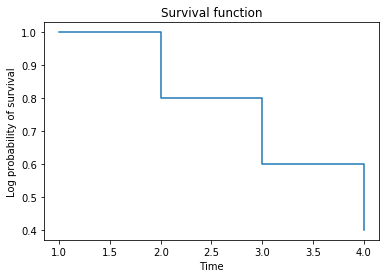

In [172]:
plot_survival_function([1,2,3,4], [1, 0.8, 0.6, 0.4], log_prob = False)

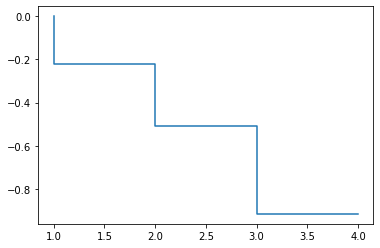

In [112]:
plt.step(np.asarray([1,2,3,4]), np.log(np.asarray([1, 0.8, 0.6, 0.4])))

In [55]:
from inspect import getmembers, isfunction
import matplotlib.pyplot as plt

functions_list = [o[0] for o in getmembers(plt) if isfunction(o[1])]

In [56]:
functions_list

['_IP_REGISTERED',
 '_auto_draw_if_interactive',
 '_get_running_interactive_framework',
 '_setp',
 '_setup_pyplot_info_docstrings',
 '_show',
 'acorr',
 'angle_spectrum',
 'annotate',
 'arrow',
 'autoscale',
 'autumn',
 'axes',
 'axhline',
 'axhspan',
 'axis',
 'axvline',
 'axvspan',
 'bar',
 'barbs',
 'barh',
 'bone',
 'box',
 'boxplot',
 'broken_barh',
 'cla',
 'clabel',
 'clf',
 'clim',
 'close',
 'cohere',
 'colorbar',
 'colormaps',
 'connect',
 'contour',
 'contourf',
 'cool',
 'copper',
 'csd',
 'cycler',
 'dedent',
 'delaxes',
 'deprecated',
 'disconnect',
 'draw',
 'draw_if_interactive',
 'errorbar',
 'eventplot',
 'figaspect',
 'figimage',
 'figlegend',
 'fignum_exists',
 'figtext',
 'figure',
 'fill',
 'fill_between',
 'fill_betweenx',
 'findobj',
 'flag',
 'gca',
 'gcf',
 'gci',
 'get',
 'get_backend',
 'get_cmap',
 'get_current_fig_manager',
 'get_figlabels',
 'get_fignums',
 'get_plot_commands',
 'get_scale_docs',
 'get_scale_names',
 'getp',
 'ginput',
 'gray',
 'grid',
 